# Project 4: West Nile Virus Prediction

Authors: Cheong Hao Han, Phua Jia Qing, Choo Wende

--------

## Content

**Part 1: Data Cleaning and Processing**
<br>
_(Project_4_Part1_WJH.ipynb)_
1. Weather Data
2. Spray Data
3. Train and Test Data
4. Merge and Save DataFrame

**Part 2: Exploratory Data Analysis**
<br>
_(Project_4_Part2_WJH.ipynb)_
1. Map Overview of Data
2. Train Data Analysis
3. Weather Data Analysis
4. Spray Data Analysis

**Part 3: Modelling**
<br>
_(Project_4_Part3_WJH.ipynb)_
1. Preprocessing
2. Modelling
3. Model Comparison
4. Kaggle Submission
5. Cost-Benefit Analysis
6. Conclusion & Recommendations


## Libraries

In [ ]:
#pip install geopy

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, date
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, \
accuracy_score, recall_score, precision_score, f1_score, silhouette_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Part 2: Modelling

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Data

In [ ]:
# use when running from colab
PATH = '/content/drive/MyDrive/DSI30/'

# use when running on local machine
# PATH = '../'

In [ ]:
# Import Train/Test merged and spray dataset
train_merged = pd.read_csv(f'{PATH}data/part2_train_merged.csv')
test_merged = pd.read_csv(f'{PATH}data/part2_test_merged.csv')

In [ ]:
# Verify Dataframe info
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10415 non-null  object 
 1   Address       10415 non-null  object 
 2   Species       10415 non-null  object 
 3   Trap          10415 non-null  object 
 4   Latitude      10415 non-null  float64
 5   Longitude     10415 non-null  float64
 6   NumMosquitos  10415 non-null  int64  
 7   WnvPresent    10415 non-null  int64  
 8   Year          10415 non-null  int64  
 9   Month         10415 non-null  int64  
 10  Day           10415 non-null  int64  
 11  Week          10415 non-null  int64  
 12  Station       10415 non-null  int64  
 13  Tavg          10415 non-null  float64
 14  DewPoint      10415 non-null  int64  
 15  Heat          10415 non-null  float64
 16  Cool          10415 non-null  float64
 17  PrecipTotal   10415 non-null  float64
 18  StnPressure   10415 non-nu

In [ ]:
# Verify Dataframe info
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           116293 non-null  int64  
 1   Date         116293 non-null  object 
 2   Address      116293 non-null  object 
 3   Species      116293 non-null  object 
 4   Trap         116293 non-null  object 
 5   Latitude     116293 non-null  float64
 6   Longitude    116293 non-null  float64
 7   Year         116293 non-null  int64  
 8   Month        116293 non-null  int64  
 9   Day          116293 non-null  int64  
 10  Week         116293 non-null  int64  
 11  Station      116293 non-null  int64  
 12  Tmax         116293 non-null  int64  
 13  Tmin         116293 non-null  int64  
 14  Tavg         116293 non-null  float64
 15  DewPoint     116293 non-null  int64  
 16  WetBulb      116293 non-null  float64
 17  Heat         116293 non-null  float64
 18  Cool         116293 non-

In [ ]:
# Convert date to date-time
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

## Preprocessing

**Clustering of Traps**
Traps will be cluster into groups using K-Means based on locations (latitude, longitude), NumMosquitos and WNV Present.

In [ ]:
# create datafrom for clustering. 
trap_df = train_merged.groupby(['Trap', 'Latitude', 'Longitude'])[['NumMosquitos','WnvPresent']].sum()
trap_df.head()

NumMosquitos  WnvPresent
Trap Latitude  Longitude                           
T001 41.953705 -87.733974            25           0
T002 41.954690 -87.800991          3710          18
T003 41.964242 -87.757639          1346          14
T004 41.962728 -87.748367            59           0
T005 41.942114 -87.776385            50           2

In [ ]:
# Instantiate standard scaler
ss=StandardScaler()
trap_sc = ss.fit_transform(trap_df)

In [ ]:
# Create list to store sihouette score
scores=[]

# loop to find best number of clusters
for n in range(2, 50, 1):
    
    # Instantiate and fit KMeans
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(trap_sc)
    
    # Compute inertia and sil score
    inertia = kmeans.inertia_
    sil = silhouette_score(trap_sc, kmeans.labels_)
    scores.append([n, inertia, sil])

# convert sil_scores to dataframe
scores_df = pd.DataFrame(scores, columns=['n_clusters', 'inertia', 'sil_score'])
scores_df.head(10)

n_clusters    inertia  sil_score
0           2  71.927697   0.925217
1           3  38.539651   0.601915
2           4  25.759062   0.597571
3           5  16.308474   0.589740
4           6   9.686410   0.552898
5           7   7.648169   0.511443
6           8   5.995324   0.519821
7           9   4.636825   0.502914
8          10   3.921662   0.496090
9          11   3.240447   0.458018

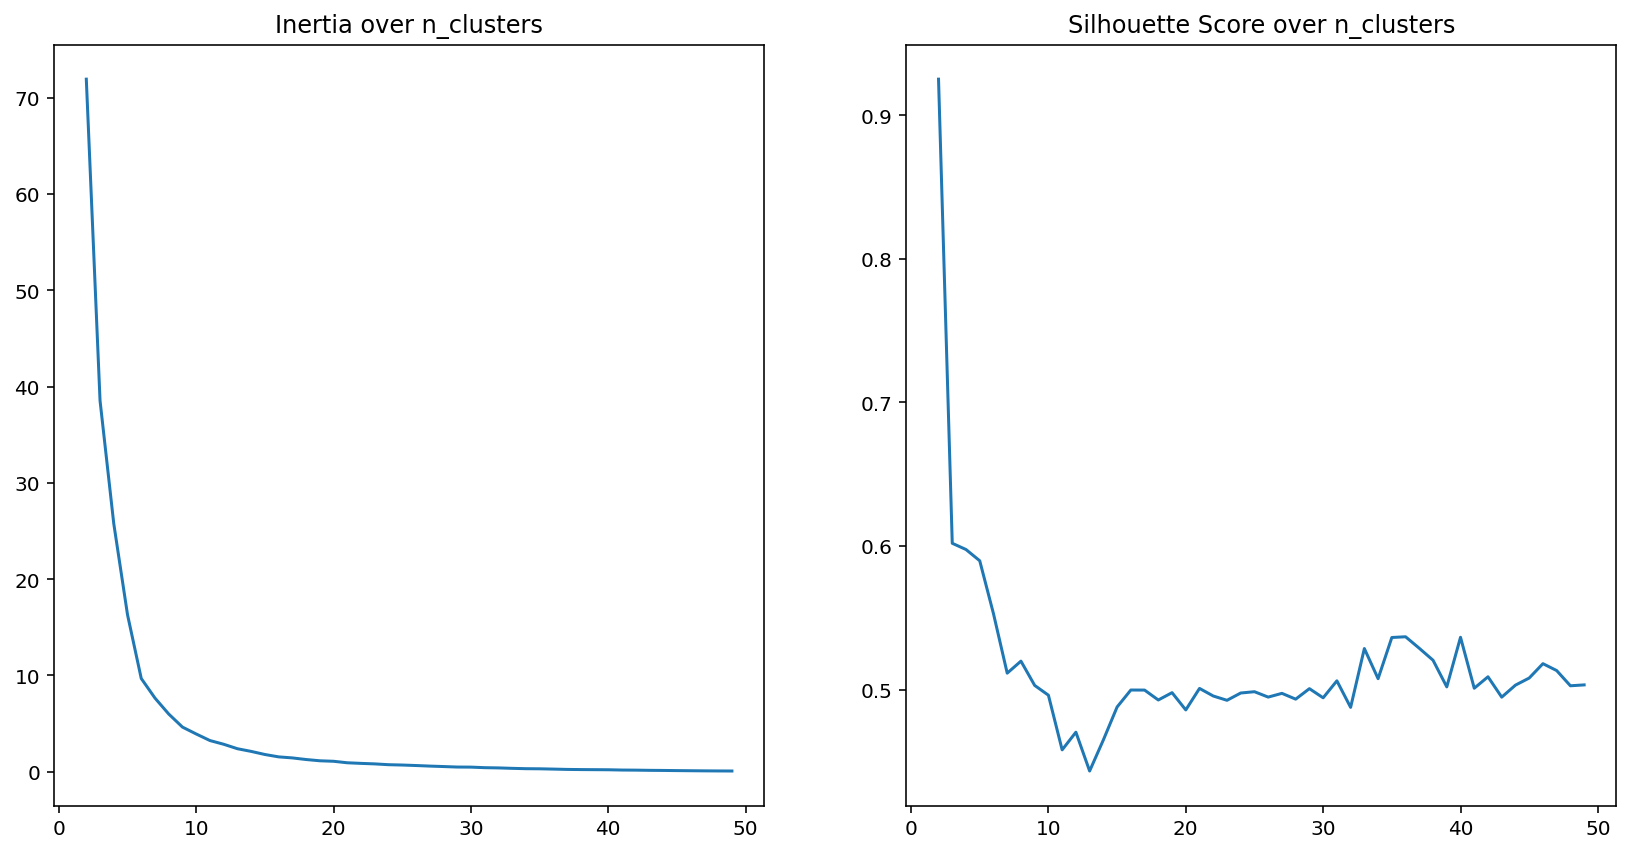

In [ ]:
# Plot inertia and silhouette score over n_clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(scores_df.n_clusters, scores_df.inertia)
axes[0].set_title('Inertia over n_clusters')
axes[1].plot(scores_df.n_clusters, scores_df.sil_score);
axes[1].set_title('Silhouette Score over n_clusters');

When n_clusters is 3, the inertia dropped significantly while still having a high silhouette score. Hence, 3 clusters will be used. 

In [ ]:
# Instantiate and fit KMeans with best sil score n 
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(trap_sc)

# Create dataframe of trap_sc clusters
trap_clusters = pd.DataFrame(kmeans.predict(trap_sc), columns=['trap_cluster'], index=trap_df.index)
trap_clusters = trap_clusters.merge(trap_df, left_index=True, right_index=True).reset_index()
trap_clusters.head()

Trap   Latitude  Longitude  trap_cluster  NumMosquitos  WnvPresent
0  T001  41.953705 -87.733974             0            25           0
1  T002  41.954690 -87.800991             2          3710          18
2  T003  41.964242 -87.757639             2          1346          14
3  T004  41.962728 -87.748367             0            59           0
4  T005  41.942114 -87.776385             0            50           2

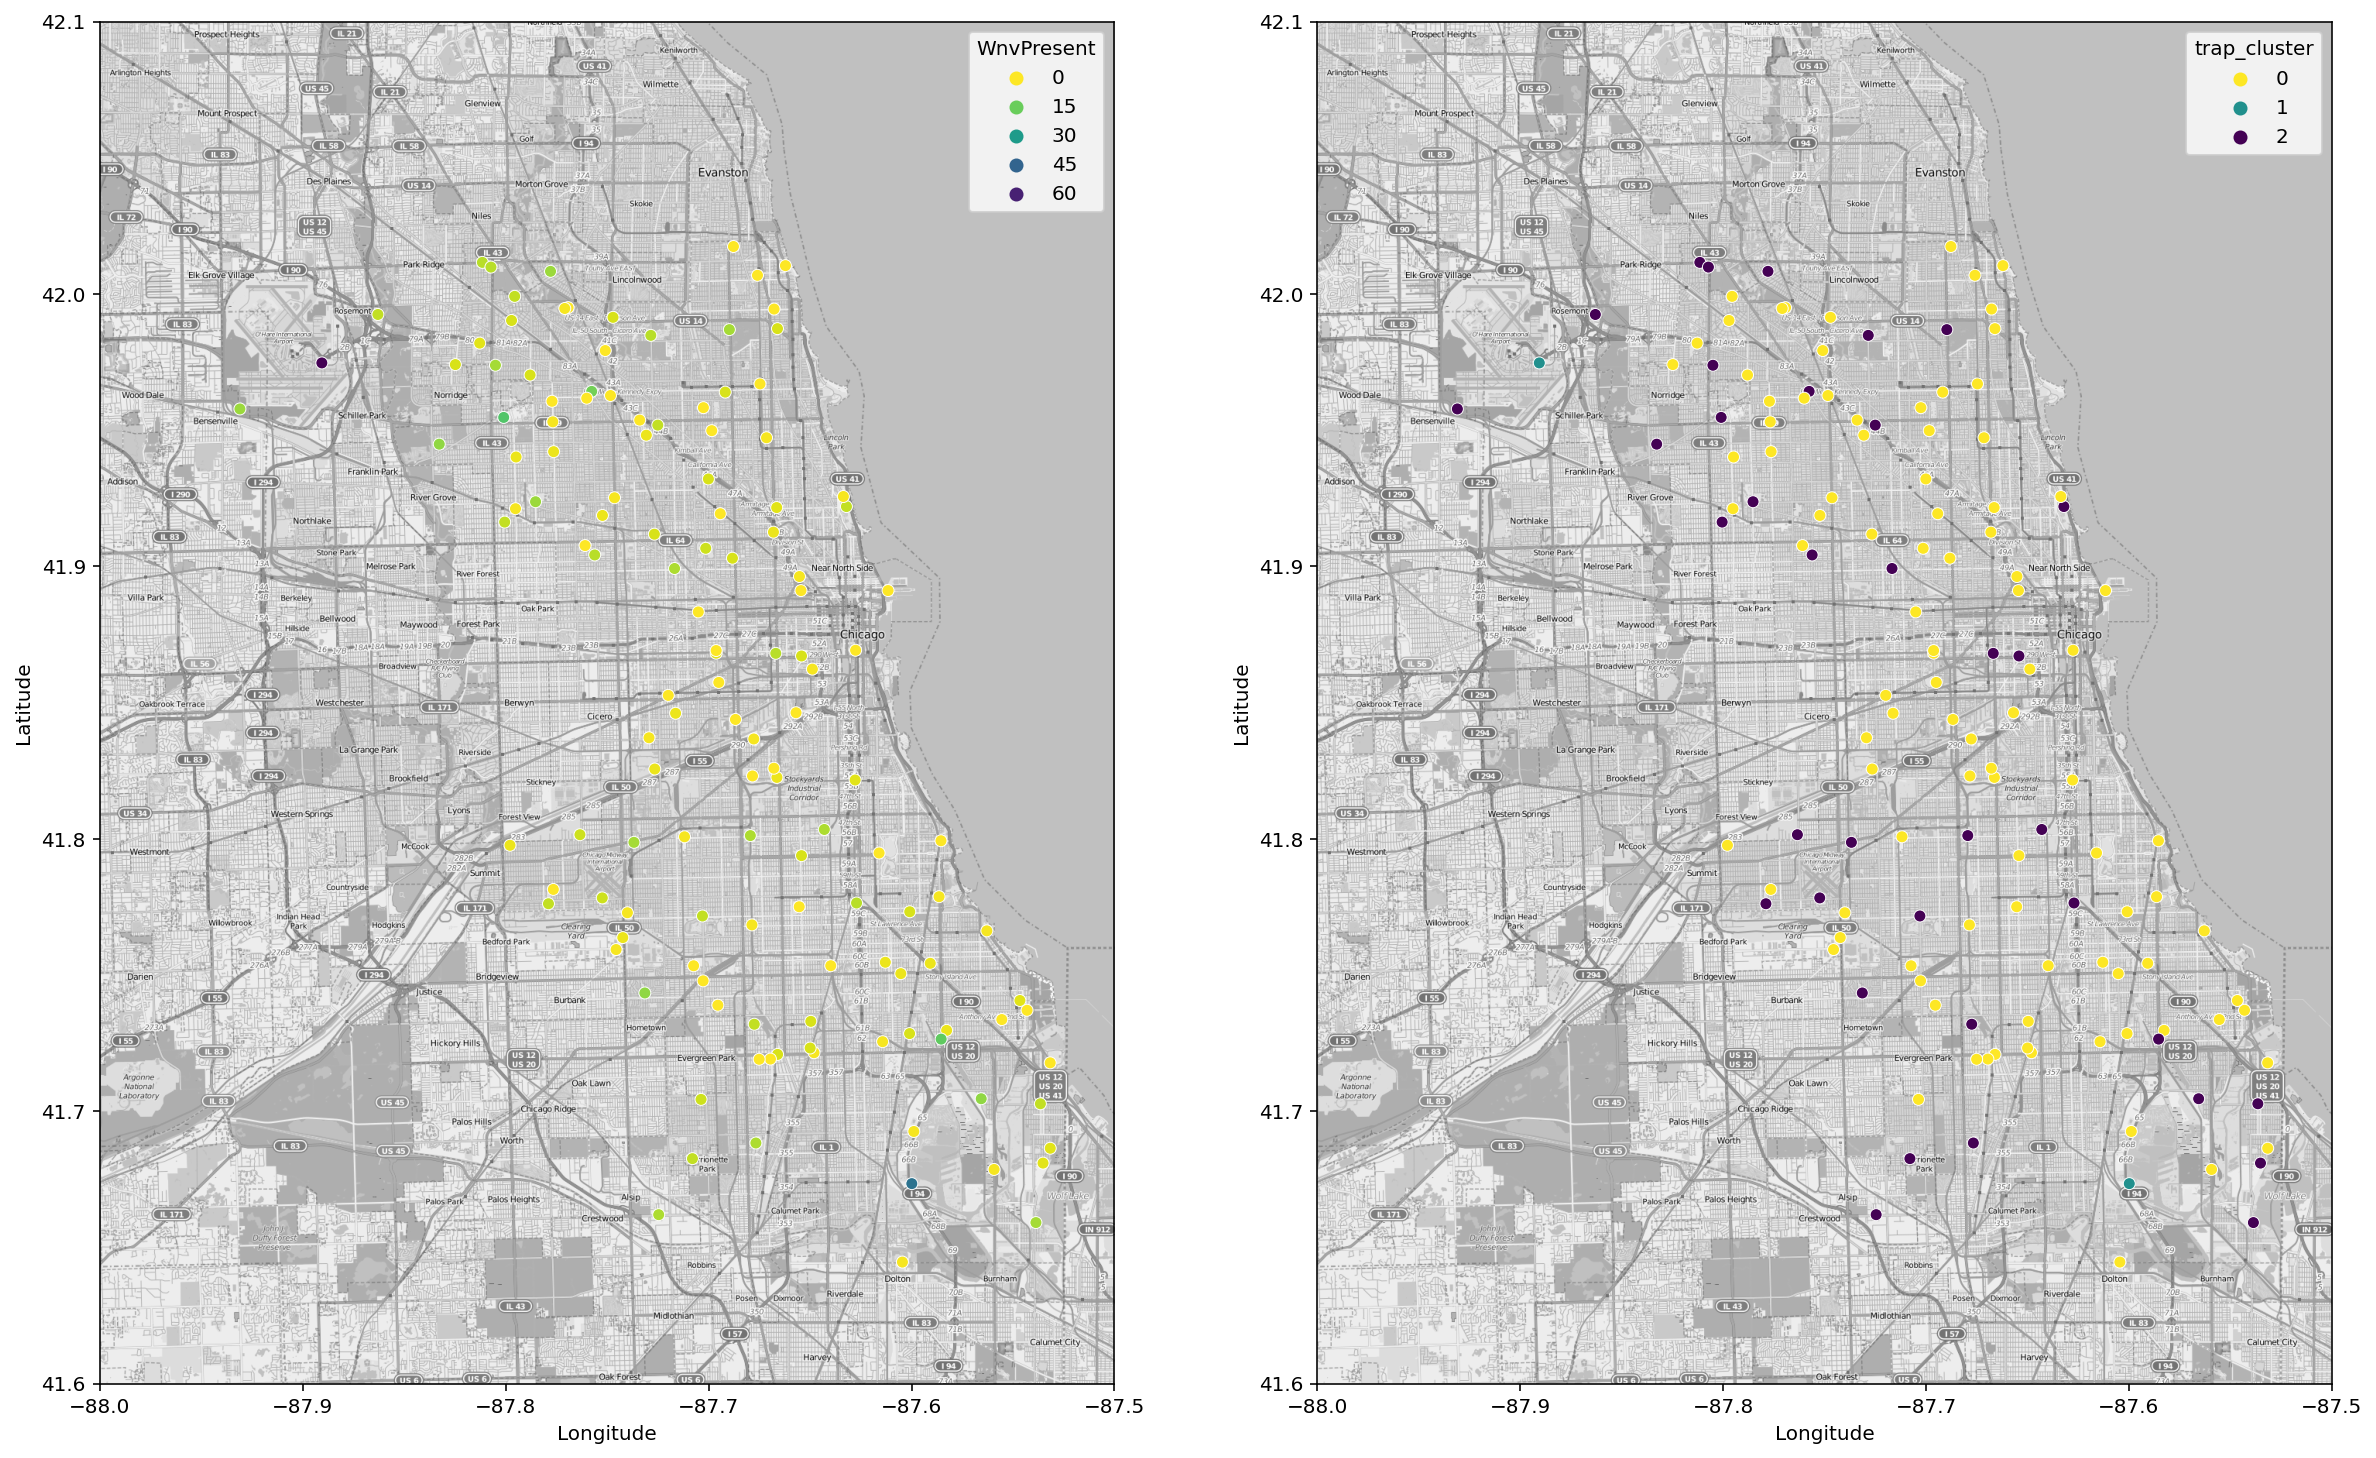

In [ ]:
# Plot map of cluster groups
fig, ax = plt.subplots(ncols=2, figsize=(20, 15))
ax=ax.ravel()

# Instantiating map variables. 
mapdata = np.loadtxt(f'{PATH}/data/mapdata_copyright_openstreetmap_contributors.txt')

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_boundary = (-88, -87.5, 41.6, 42.1)

# plot WNV Present data
ax[0].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_boundary, aspect=aspect)
sns.scatterplot(data = trap_clusters, x='Longitude', y='Latitude', hue='WnvPresent', ax=ax[0],
                palette='viridis_r');


# plot cluster result
ax[1].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_boundary, aspect=aspect)
sns.scatterplot(data = trap_clusters, x='Longitude', y='Latitude', hue='trap_cluster', ax=ax[1],
                palette='viridis_r');


**Observations**:

The traps are grouped into the 3 clusters. 

- Group 0 (mod_wnv): These traps have moderate level of WMV Present.
- Group 1 (high_wnv): These are anomaly as they have very high WMV Present. 
- Group 2 (low_wnv): These traps have low level of WMV Present.


**Label Traps in Train and Test data**

**Trap Data**

In [ ]:
# Create trap_cluster column for train_merged dataframe
train_merged=train_merged.merge(trap_clusters[['Trap','trap_cluster']], left_on='Trap', right_on='Trap')
train_merged.head(2)

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Trap  Latitude  Longitude  NumMosquitos  \
0  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991             1   
1          CULEX RESTUANS  T002  41.95469 -87.800991             1   

   WnvPresent  Year  Month  ...  Tavg  DewPoint  Heat  Cool  PrecipTotal  \
0           0  2007      5  ...  74.0        58   0.0   9.0          0.0   
1           0  2007      5  ...  74.0        58   0.0   9.0          0.0   

   StnPressure  AvgSpeed  DayDuration    R_Humid  trap_cluster  
0        29.39       6.5          896  57.398449             2  
1        29.39       6.5          896  57.398449             2  

[2 rows x 23 columns]

**Test Data**

In [ ]:
# Find traps in test data that are not in train data
new_traps = list(set(test_merged['Trap'].unique())-set(train_merged['Trap'].unique()))
new_traps

['T090A',
 'T002B',
 'T200B',
 'T065A',
 'T200A',
 'T128A',
 'T090B',
 'T218B',
 'T218C',
 'T002A',
 'T090C',
 'T145',
 'T234',
 'T218A']

In [ ]:
# Create dataframe of new traps. 
new_traps_loc = test_merged.groupby(['Trap'])[['Latitude', 'Longitude']].max().loc[new_traps]
new_traps_loc.head(3)

Latitude  Longitude
Trap                       
T090A  41.690423 -87.656929
T002B  41.951878 -87.789234
T200B  41.646541 -87.543762

In [ ]:
# New traps clusters will be imputed using KNeighborsClassifier()

# Define X and y using train data. 
X = train_merged[['Latitude', 'Longitude']]
y= train_merged['trap_cluster']

# Instantiate KNeighborsClassifier()
knn=KNeighborsClassifier()

# Instantiate, fit StandardScaler
# Transform X and new traps locations.
ss=StandardScaler()
Xsc=ss.fit_transform(X)

test=new_traps_loc[['Latitude', 'Longitude']]
testsc=ss.transform(test)

# Fit KNeighborsClassifier()
knn.fit(Xsc, y);

# Predict clusters for new trap location
pred = knn.predict(testsc)

In [ ]:
# Create columns in new_traps_loc dataframe
new_traps_loc['trap_cluster']=pred

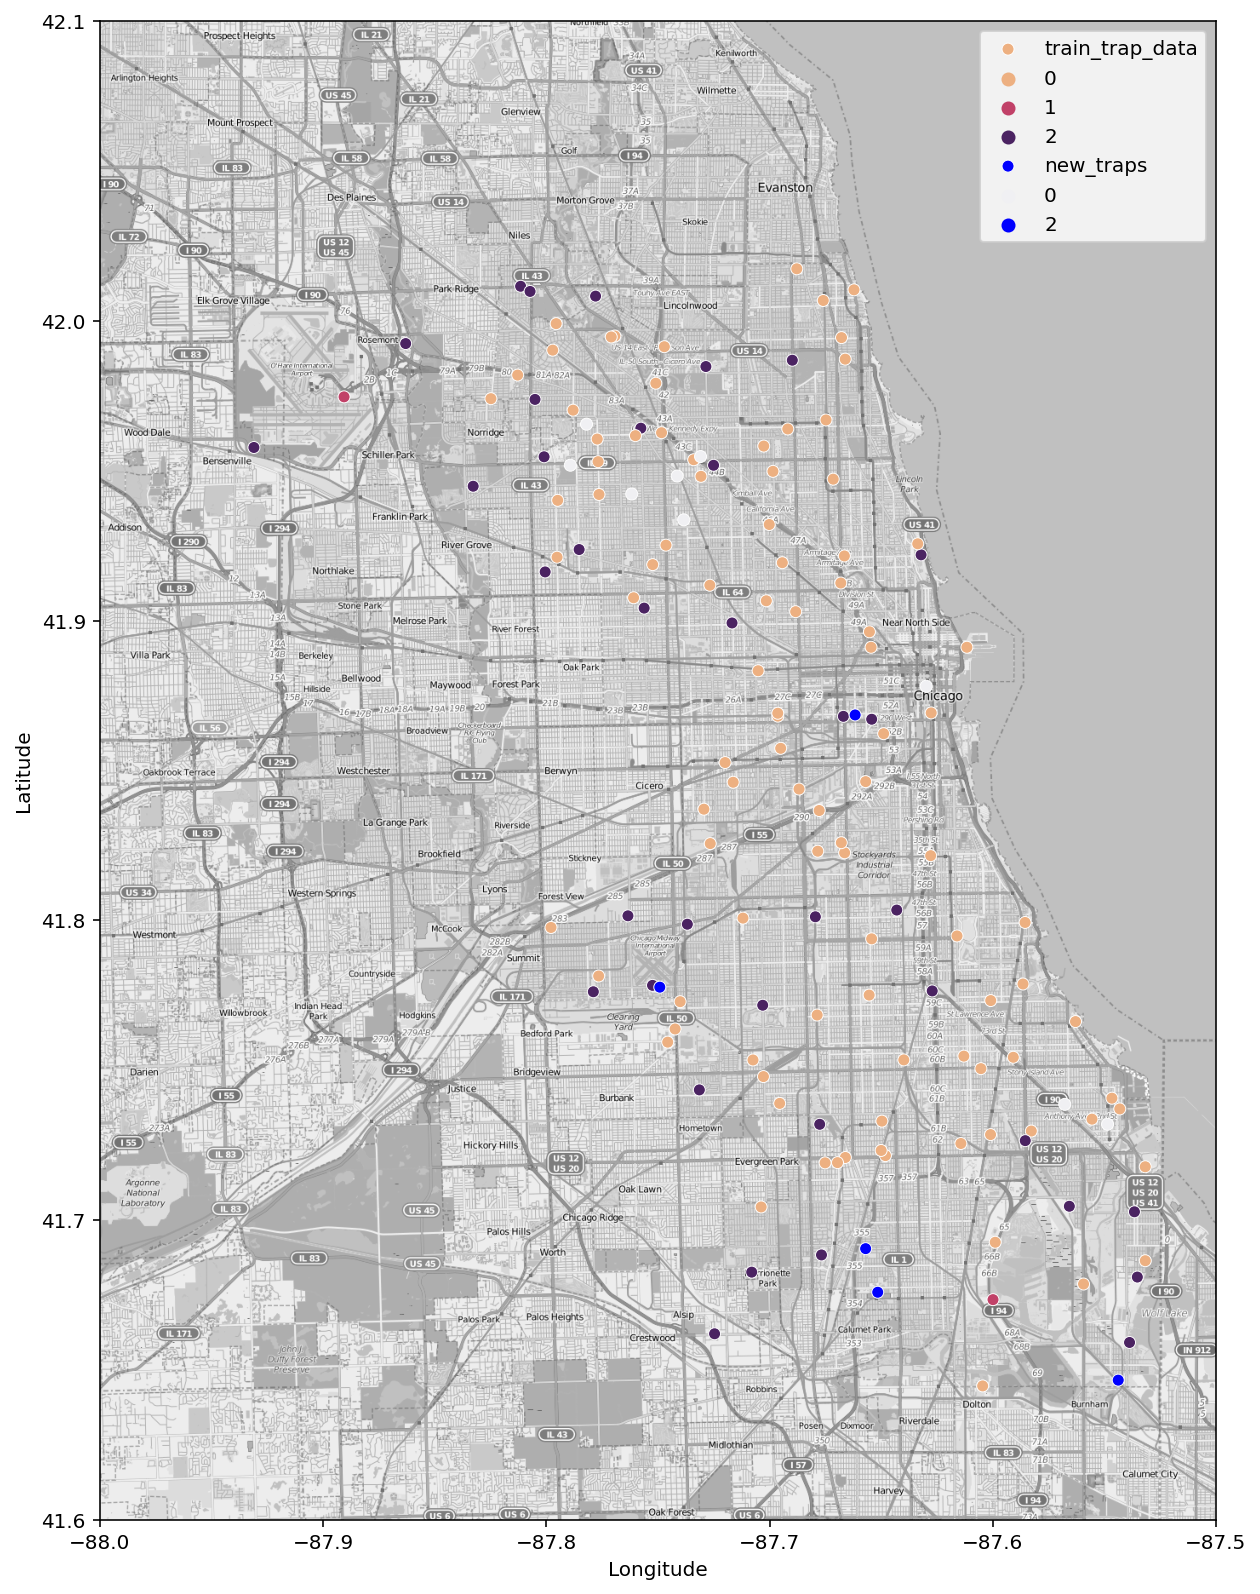

In [ ]:
# plot new traps clusters on map to verify predictions
plt.figure(figsize=(10,15))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_boundary, aspect=aspect)
sns.scatterplot(data = trap_clusters, x='Longitude', y='Latitude', hue='trap_cluster',
                palette='flare', label='train_trap_data');

sns.scatterplot(data = new_traps_loc, x='Longitude', y='Latitude', hue='trap_cluster',
                palette='light:b', label='new_traps');
plt.legend();

In [ ]:
# Create dataframe for trap clusters
cluster_df = pd.concat([trap_clusters[['Trap','trap_cluster']],
                           new_traps_loc[['trap_cluster']].reset_index()])

# Display first 5 and last 5 rows of trap_clusters
cluster_df

Trap  trap_cluster
0    T001             0
1    T002             2
2    T003             2
3    T004             0
4    T005             0
..    ...           ...
9   T002A             0
10  T090C             2
11   T145             0
12   T234             0
13  T218A             0

[151 rows x 2 columns]

In [ ]:
test_merged=test_merged.merge(cluster_df, left_on='Trap', right_on='Trap')
test_merged.head(2)

Id       Date                                            Address  \
0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Trap  Latitude  Longitude  Year  Month  Day  ...  \
0  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991  2008      6   11  ...   
1          CULEX RESTUANS  T002  41.95469 -87.800991  2008      6   11  ...   

   Cool  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0   9.0          0.0        29.28     29.99          8.9         18      10.0   
1   9.0          0.0        29.28     29.99          8.9         18      10.0   

   DayDuration    R_Humid  trap_cluster  
0          910  53.405643             2  
1          910  53.405643             2  

[2 rows x 28 columns]

**Rename trap_cluster name for clarity**

In [ ]:
rename_dict = {0:'mod_wnv',
               1:'high_wnv',
               2:'low_wnv'}

train_merged['trap_cluster']=train_merged['trap_cluster'].map(rename_dict)
test_merged['trap_cluster']=test_merged['trap_cluster'].map(rename_dict)

### One Hot Encoding

In [ ]:
train_merged = pd.get_dummies(train_merged, columns = ['Species', 'trap_cluster'], drop_first = True)

In [ ]:
test_merged = pd.get_dummies(test_merged, columns = ['Species', 'trap_cluster'], drop_first = True)

**Define X and y for Modelling**
<br>
As mentioned in Data Cleaning, NumMosquitos are not present in test dataset. Thus, the column will be drop for modelling.
<br>
There are Long and Lat columns to determine Address, thus, the column can be drop for modelling.
<br>
The Date column has been converted to Day, Month, Year. Therefore, Date column will be drop for modelling.

In [ ]:
X = train_merged.drop(columns = ['WnvPresent', 'Date', 'Address', 'Trap', 'NumMosquitos', 
                                 'Species_CULEX TERRITANS', 'Species_CULEX TARSALIS', 'Species_CULEX SALINARIUS', 
                                 'Station', 'Trap', 'Latitude', 'Longitude'])
y = train_merged['WnvPresent']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                  test_size = 0.2,
                                                  random_state = 42,
                                                  stratify =y)

## Modelling

In [ ]:
model_list = []
best_score_list = []
train_score_list = []
test_score_list = []
best_est_list = []
roc_auc_score_list = []

Function for modelling

In [ ]:
def modelling_basic(model_name, model, pipe_params):
    
    # Define the pipeline first
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        (model_name, model)
    ])


    # Define grid search
    gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5,
                      scoring = 'roc_auc')
    
    # Do fitting
    gs.fit(X_train, y_train)
    
    model_list.append(model)
    best_score_list.append(gs.best_score_)
    train_score_list.append(gs.score(X_train, y_train))
    test_score_list.append(gs.score(X_val, y_val))
    best_est_list.append(gs.best_params_)
    
    #Display gridsearch result
    print(f"{model} Best Score: {gs.best_score_}")
    print(f"{model} Train Score: {gs.score(X_train, y_train)}")
    print(f"{model} Test Score: {gs.score(X_val, y_val)}")
    print(" ")
    print(f"{model} Best estimators: {gs.best_params_}")
    print(" ")
    print(" ")

    #The coef display
    if model_name == 'nb': 
        print("Determinants for WNV")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        log_prob_diff = gs.best_estimator_.steps[1][1].feature_log_prob_[1] - gs.best_estimator_.steps[1][1].feature_log_prob_[0]
        df_coef = pd.DataFrame(log_prob_diff, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(10))

    elif model_name == 'lr':
        print("Strong determinants for WNV")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.lr.coef_
        coef_val = np.exp(coef_val).T
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(15))

    elif model_name == 'rf':
        print("Strong determinants for WNV")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.rf.feature_importances_
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(10))

    elif model_name == 'ab':
        print("Strong determinants for WNV")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.ab.feature_importances_
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(10))

    elif model_name == 'et':
        print("Strong determinants for WNV")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.et.feature_importances_
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(10))

    else:
        pass


    # The confusion matrix
    preds = gs.predict(X_val)

    cm = confusion_matrix(y_val, preds)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()

    models = ["Specificity", "Accuracy", "Sensitivity / Recall", "Precision", "F1 Score", "Roc Auc Score"]

    data_1 = [(tn / (tn+fp)),
              accuracy_score(y_val, preds),
              recall_score(y_val, preds),
              precision_score(y_val, preds),
              f1_score(y_val, preds),
              roc_auc_score(y_val, preds)
             ]
    
    roc_auc_score_list.append(roc_auc_score(y_val, preds))

    cm_comparison = pd.DataFrame(data=data_1, 
                                 index=models,
                                 columns = ["Calculation"])
    print(" ")
    print("Model metrics")
    display(cm_comparison)   

    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')



### Logistics Regression

In [ ]:
lr_pipe_params = {
        'sampling__sampling_strategy': ['minority'], # ['auto', 'minority', 'not minority'],
        'sampling__k_neighbors': [2], #[2, 3, 5],
        'lr__C': [1], # [0.1, 0.3, 0.5, 1]
        'lr__random_state': [28] 
}

LogisticRegression(max_iter=400) Best Score: 0.8218345899972862
LogisticRegression(max_iter=400) Train Score: 0.8314802389070636
LogisticRegression(max_iter=400) Test Score: 0.7956549785743906
 
LogisticRegression(max_iter=400) Best estimators: {'lr__C': 1, 'lr__random_state': 28, 'sampling__k_neighbors': 2, 'sampling__sampling_strategy': 'minority'}
 
 
Strong determinants for WNV


coef
Month                           103045.832353
DayDuration                      20819.812589
Day                                 22.102443
Species_CULEX PIPIENS/RESTUANS       9.676741
Species_CULEX PIPIENS                7.685892
Tavg                                 5.483720
Week                                 4.823203
Species_CULEX RESTUANS               4.704773
Heat                                 2.506906
DewPoint                             2.052787
Year                                 1.688498
PrecipTotal                          1.211494
trap_cluster_low_wnv                 0.968070
AvgSpeed                             0.866899
StnPressure                          0.742503

 
Model metrics


Calculation
Specificity              0.668018
Accuracy                 0.674508
Sensitivity / Recall     0.790909
Precision                0.117251
F1 Score                 0.204225
Roc Auc Score            0.729464

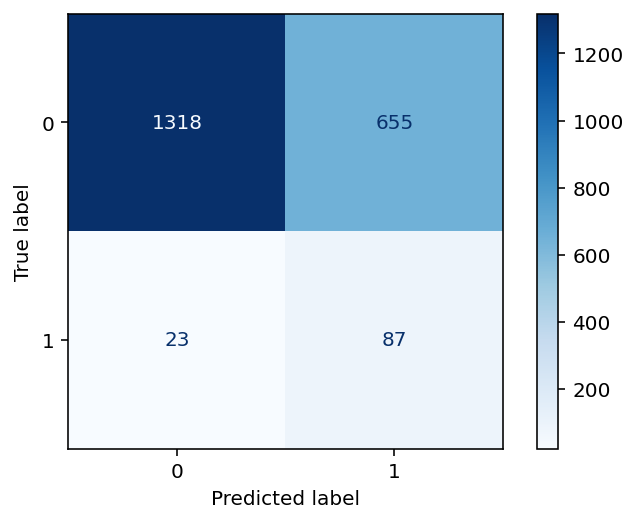

In [ ]:
modelling_basic('lr', LogisticRegression(solver='lbfgs', max_iter=400), lr_pipe_params)

### K Nearest Neighbors

In [ ]:
knn_pipe_params = {
    'knn__n_neighbors': [5], #[3, 4, 5] 
    'knn__leaf_size': [50] #[40, 50, 60]
}

KNeighborsClassifier() Best Score: 0.7367795457774405
KNeighborsClassifier() Train Score: 0.8639216064599363
KNeighborsClassifier() Test Score: 0.6971916324932037
 
KNeighborsClassifier() Best estimators: {'knn__leaf_size': 50, 'knn__n_neighbors': 5}
 
 
 
Model metrics


Calculation
Specificity              0.899645
Accuracy                 0.870859
Sensitivity / Recall     0.354545
Precision                0.164557
F1 Score                 0.224784
Roc Auc Score            0.627095

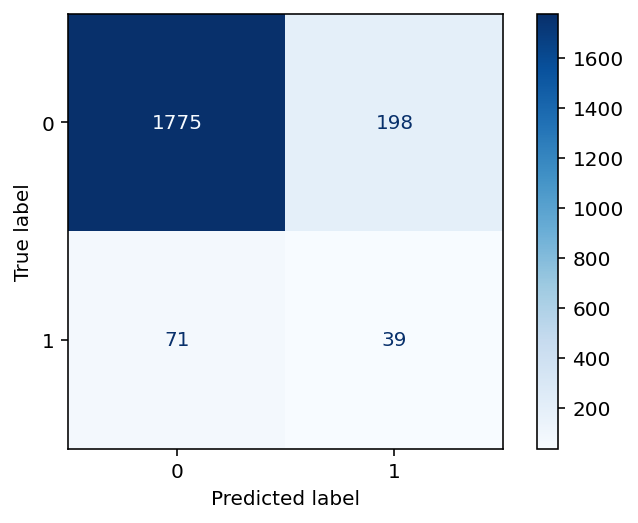

In [ ]:
modelling_basic('knn', KNeighborsClassifier(), knn_pipe_params)

### Random Forest

In [ ]:
rf_pipe_params = {
             'rf__n_estimators': [190], #[100, 150, 190], 
             'rf__max_depth': [6], #[4, 5, 6],
             'rf__random_state': [28]
}

RandomForestClassifier() Best Score: 0.833839694421562
RandomForestClassifier() Train Score: 0.8663227721973921
RandomForestClassifier() Test Score: 0.8150992950283371
 
RandomForestClassifier() Best estimators: {'rf__max_depth': 6, 'rf__n_estimators': 190, 'rf__random_state': 28}
 
 
Strong determinants for WNV


coef
DayDuration           0.195970
Week                  0.182512
Month                 0.132791
Year                  0.073282
Tavg                  0.064546
trap_cluster_mod_wnv  0.063504
Cool                  0.056941
DewPoint              0.043106
AvgSpeed              0.039593
R_Humid               0.028856

 
Model metrics


Calculation
Specificity              0.747086
Accuracy                 0.745079
Sensitivity / Recall     0.709091
Precision                0.135182
F1 Score                 0.227074
Roc Auc Score            0.728088

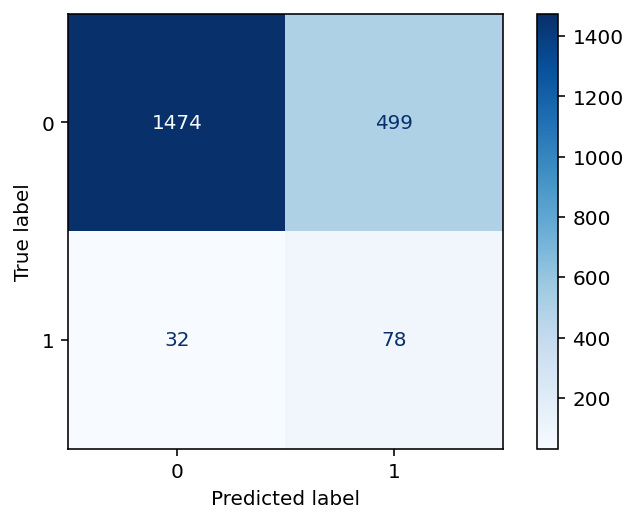

In [ ]:
modelling_basic('rf', RandomForestClassifier(), rf_pipe_params)

### AdaBoost

In [ ]:
ada_pipe_params = {'ab__learning_rate': [0.2], #[0.2, 0.3],
                   'ab__n_estimators': [100], #[100, 150, 200]
                   'ab__random_state': [28]
                  }

AdaBoostClassifier() Best Score: 0.8335172088677429
AdaBoostClassifier() Train Score: 0.8493678869280744
AdaBoostClassifier() Test Score: 0.8113279270146985
 
AdaBoostClassifier() Best estimators: {'ab__learning_rate': 0.2, 'ab__n_estimators': 100, 'ab__random_state': 28}
 
 
Strong determinants for WNV


coef
Year                    0.13
DewPoint                0.13
Week                    0.13
Tavg                    0.12
trap_cluster_mod_wnv    0.09
AvgSpeed                0.08
StnPressure             0.08
DayDuration             0.05
R_Humid                 0.05
Species_CULEX RESTUANS  0.05

 
Model metrics


Calculation
Specificity              0.779017
Accuracy                 0.773404
Sensitivity / Recall     0.672727
Precision                0.145098
F1 Score                 0.238710
Roc Auc Score            0.725872

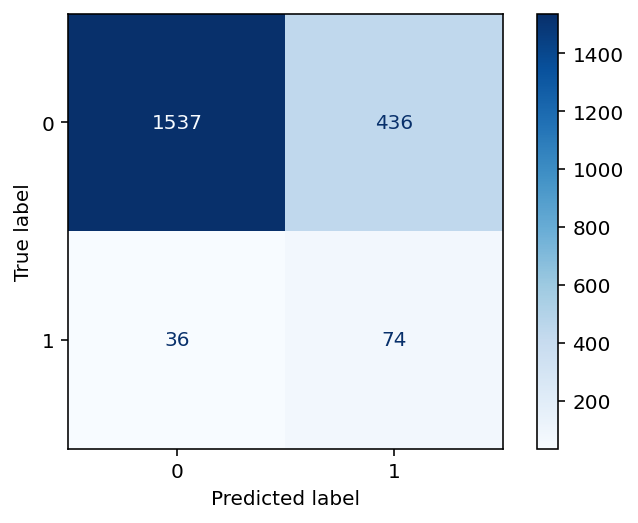

In [ ]:
modelling_basic('ab', AdaBoostClassifier(), ada_pipe_params)

### GradientBoost

In [ ]:
gb_pipe_params = {'gb__learning_rate': [0.2], #[0.2, 0.3],
                  'gb__max_depth': [4], #[3, 4],
                  'gb__n_estimators': [100], #[100, 200, 300],
                  'gb__random_state': [28]
                 }

GradientBoostingClassifier() Best Score: 0.8344580795870385
GradientBoostingClassifier() Train Score: 0.8884041088789568
GradientBoostingClassifier() Test Score: 0.8180528037598489
 
GradientBoostingClassifier() Best estimators: {'gb__learning_rate': 0.2, 'gb__max_depth': 4, 'gb__n_estimators': 100, 'gb__random_state': 28}
 
 
 
Model metrics


Calculation
Specificity              0.886974
Accuracy                 0.864138
Sensitivity / Recall     0.454545
Precision                0.183150
F1 Score                 0.261097
Roc Auc Score            0.670760

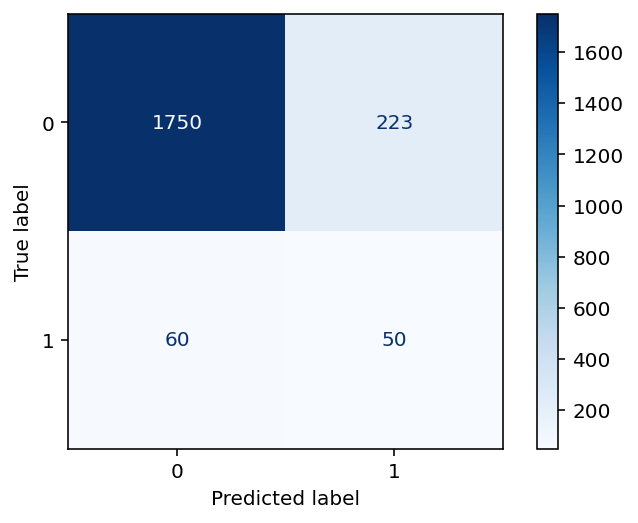

In [ ]:
modelling_basic('gb', GradientBoostingClassifier(), gb_pipe_params)

### Extra Tree

In [ ]:
et_pipe_params = {'et__n_estimators': [100], #[100, 200],
             'et__max_depth': [5], #[4, 5],
             'et__max_features': ['sqrt'], #['sqrt', 'log2']
             'et__random_state': [28]
            }

ExtraTreesClassifier() Best Score: 0.8293494120682208
ExtraTreesClassifier() Train Score: 0.8499321810348799
ExtraTreesClassifier() Test Score: 0.8086762198774363
 
ExtraTreesClassifier() Best estimators: {'et__max_depth': 5, 'et__max_features': 'sqrt', 'et__n_estimators': 100, 'et__random_state': 28}
 
 
Strong determinants for WNV


coef
Month                   0.159028
Species_CULEX RESTUANS  0.135263
Week                    0.129281
DayDuration             0.123731
trap_cluster_mod_wnv    0.094012
Year                    0.093393
Cool                    0.049381
DewPoint                0.035491
Tavg                    0.034601
trap_cluster_low_wnv    0.024946

 
Model metrics


Calculation
Specificity              0.722757
Accuracy                 0.722516
Sensitivity / Recall     0.718182
Precision                0.126198
F1 Score                 0.214674
Roc Auc Score            0.720470

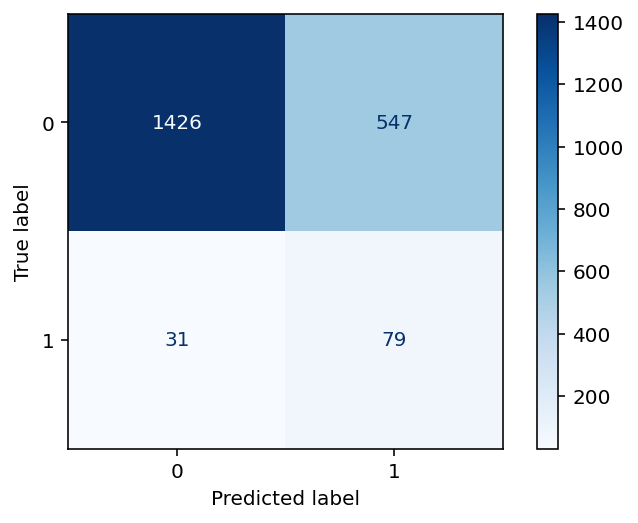

In [ ]:
modelling_basic('et', ExtraTreesClassifier(), et_pipe_params)

## Model Comparison 

In [ ]:
model_comparision = pd.DataFrame({"models": model_list, 
                              "best score": best_score_list,
                              "train scores": train_score_list, 
                              "test scores": test_score_list, 
                              "roc_auc_score": roc_auc_score_list
                             })

In [ ]:
model_comparision

models  best score  train scores  test scores  \
0  LogisticRegression(max_iter=400)    0.821835      0.831480     0.795655   
1            KNeighborsClassifier()    0.736780      0.863922     0.697192   
2          RandomForestClassifier()    0.833840      0.866323     0.815099   
3              AdaBoostClassifier()    0.833517      0.849368     0.811328   
4      GradientBoostingClassifier()    0.834458      0.888404     0.818053   
5            ExtraTreesClassifier()    0.829349      0.849932     0.808676   

   roc_auc_score  
0       0.729464  
1       0.627095  
2       0.728088  
3       0.725872  
4       0.670760  
5       0.720470

Based on the result above, the Logistic Regression model has the highest ROC AUC score (0.729). Random Forest has the second highest ROC AUC score (0.728). However, comparing the train score and test score, it is apparent that Logistic Regression is better compared to Random Forest in terms of overfitting. Thus, the Logistic Regression model is just as comparable in distinguishing between traps with and without WNV presence.

## Kaggle

Drop the same columns in the test dataset

In [ ]:
test_merged.drop(columns =['Tmax', 'Tmin','WetBulb','ResultSpeed','ResultDir',
                           'SeaLevel', 'Date', 'Address', 'Trap', 
                           'Species_CULEX TERRITANS', 'Species_CULEX TARSALIS', 'Species_CULEX SALINARIUS', 
                           'Station', 'Latitude', 'Longitude'], inplace = True)

Instantiate the chosen best model and do the prediction for the test set

In [ ]:
lr = LogisticRegression(max_iter=400, random_state = 28)

In [ ]:
ss = StandardScaler()
sm = SMOTE()

In [ ]:
X_train_sc, X_val_sc = ss.fit_transform(X_train), ss.transform(X_val)

In [ ]:
X_train_smsc, y_train_sm = sm.fit_resample(X_train_sc, y_train)

In [ ]:
lr.fit(X_train_smsc, y_train_sm)

LogisticRegression(max_iter=400, random_state=28)

In [ ]:
test_merged_sc = ss.transform(test_merged.drop(columns=['Id', 'Species_UNSPECIFIED CULEX']))

In [ ]:
pred = lr.predict_proba(test_merged_sc)

Since the predict proba is utilised, the prediction for 1 will need to be unpacked and append properly for kaggle submission

In [ ]:
preds = []
for i in pred:
    preds.append(i[1])

In [ ]:
kaggle_test = zip(test_merged['Id'], preds)

In [ ]:
kaggle_test = pd.DataFrame(kaggle_test, columns = ["Id", "WnvPresent"])

In [ ]:
kaggle_test.to_csv(f'{PATH}data/submission_wjh.csv', index=False)

In [ ]:
kaggle_test.head()

Id    WnvPresent
0   1  1.704278e-06
1   2  5.901834e-07
2   3  1.962972e-06
3   4  1.807260e-08
4   5  1.807260e-08

In [ ]:
kaggle_test.tail()

Id  WnvPresent
116288  116289    0.013657
116289  116290    0.013657
116290  116291    0.013657
116291  116292    0.013657
116292  116293    0.013657

The Kaggle score using Logistic Regression model

![](https://drive.google.com/uc?export=view&id=1nmV6pFSQlktswZ4BByVqXrXrQaGq6Sdb)


## Cost-Benefit Analaysis

#### **Cost Analysis**

The Chicago Department of Public Health (CDPH) has been spraying Zenivex (as approved for use by the U.S Enivronmental Protection Agency) which is the most common used pesticide to control mosquitoes. 

- Zenivex cost around USD332 per gallon (128 ounces) ([*source*](https://www.health.nd.gov/sites/www/files/documents/Files/MSS/WNV/Resources/North%20Dakota%20Mosquito%20Control%20Product%20List%20Tabulation%202022.pdf))

Spraying of Zenivex begins at dusk 8:00pm and continue through the night until approximately 1:00am, with with licensed mosquito abatement technicians in trucks dispensing an ultra-low-volume spray. ([*source*](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_living/news/2021/august/city-to-spray-insecticide-wednesday-to-kill-mosquitoes.html)) These are the hours where mosquitoes are the most active and humans are mostly indoors which would reduce the human interaction with the pesticide. CDPH staff has also distributed door hangers in the affected areas notifying residents that the spraying will occur.

- Spray rate is about 1.5 ounces per acre ([*source*](https://abc7chicago.com/archive/9206273/))

The size of Chicago is about 150,100 acres in area.

- Spray cost for whole of Chicago:
  - Spray Amount: 150100 / 1.5 = 100066.67
  - Spray Amount in Gallons: 100066.67 / 128 = 781.77
  - Cost of Zenivex Needed: 781.77 * USD332 = USD259,547.64

In the event of Chicago spraying the pesticide twice in each quarter, the annual cost of spraying would be USD2,076,381.12 (USD259,547.64 * 8).

#### **Benefit Analysis**

Benefits of spraying would included reducing the number of people falling sick and dying, increasing workplace productivity as lesser people are taking medical leave, also hospital expenses can be saved as there will be lesser WNV patients. 

The median household income of Illinois, is USD65,886 (Chicago is a city in Illinois) ([*source*](https://worldpopulationreview.com/state-rankings/median-household-income-by-state)). We can calculate the loss the city would face from an weakened workforce. 

In 2021, there were 64 human cases reported positive for WNV as reported by NBC Chicago ([*source*](https://www.nbcchicago.com/news/local/west-nile-virus-reported-in-seven-illinois-counties-chicago-area/2864963/)). Roughly 12 people (20% of 64 people) would develop worse symptoms which would lead to them taking medical leave. Assuming that it takes 14 days to recover, this would result in a total income loss of USD35,729 (((USD55295 / 260 Working Days) * 14 Medical Leave) * 12 people). 

The average hospital expenses of a WNV patient is USD25,000 ([*source*](https://www.modernhealthcare.com/article/20140211/NEWS/302119972/west-nile-virus-has-cost-u-s-almost-800-million-study-says)). Hence, the total monetary loss caused by WNV is around USD335,729.

## Conclusion & Recommendations

Spraying is costly and has temporal effect (last about 2 weeks) in mitigating WNV. 

Based on historical data, mosquito number starts to increase when:

1. Heat level decrease
2. Cool level increase
3. PrecipTotal increase

Based on the model features coefficients, the top 15 dominant features identified by the logistic regression model are: 

1. DayDuration (mosquito are more active at night)
2. day, week, month, year (these seasonal trends that is related weather conditions, which affect mosquito activities)
3. The CULEX PIPIENS and RESTUANS are the species carrying WNV.
4. trap_cluster_low_wnv (this the cluster identified by KMeans model)
5. Tavg and heat (High temperature promots mosquito activities)
6. R-Humid, PrecipTotal and Dewpoint (high moisture increases mosquito activities)
7. Avg Wind Speed (low wind speed promotes mosquito activities as they are poor flyers)

Hence, spraying is recommneded around mid July where weather conditions favours mosquitos activities. As spraying is costly, spraying can be done at  areas with high number of mosquitos and WNV present expected based on model prediction. The top three areas based on past history are:
1. T900: ORD Terminal 5, O'Hare International Airport,
2. T115: South Doty Avenue, Chicago, IL, USA
3. T002: 4100 North Oak Park Avenue, Chicago, IL 60634,




##### References:

(n.d.). Centers for Disease Control and Prevention. https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf

Chicago to spray in some areas for west Nile virus. (09, 8). ABC7 Chicago. https://abc7chicago.com/archive/9206273/

City to spray insecticide Wednesday to kill mosquitoes. (2021, August 23). City of Chicago. https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_living/news/2021/august/city-to-spray-insecticide-wednesday-to-kill-mosquitoes.html

Cooling degree day (CDD) definition. (2005, May 25). Investopedia. https://www.investopedia.com/terms/c/colddegreeday.asp

Heating degree day (HDD) definition. (2005, May 24). Investopedia. https://www.investopedia.com/terms/h/heatingdegreeday.asp

How long do mosquitoes live... And what that means for you. (2022, April 27). MMPC. https://www.mandmpestcontrol.com/how-long-do-mosquitoes-live-and-what-that-means-for-you/

How to calculate grains of moisture. (n.d.). Sciencing. https://sciencing.com/calculate-grains-moisture-6085656.html

Median household income by state 2022. (n.d.). 2022 World Population by Country. https://worldpopulationreview.com/state-rankings/median-household-income-by-state

(n.d.). North Dakota Department of Health | Department of Health. https://www.health.nd.gov/sites/www/files/documents/Files/MSS/WNV/Resources/North%20Dakota%20Mosquito%20Control%20Product%20List%20Tabulation%202022.pdf)

Temperature, dewpoint, and relative humidity calculator. (n.d.). Calculate Temperature, Dewpoint, or Relative Humidity. https://bmcnoldy.rsmas.miami.edu/Humidity.html

Variation in adult longevity of Culex pipiens f. pipiens, vector of the West Nile Virus. (n.d.). PubMed. https://pubmed.ncbi.nlm.nih.gov/25284257/

West Nile virus has cost U.S. almost $800 million, study says. (2014, February 11). Modern Healthcare. https://www.modernhealthcare.com/article/20140211/NEWS/302119972/west-nile-virus-has-cost-u-s-almost-800-million-study-says

West Nile virus reported in 7 Illinois counties, Chicago area. (2022, June 24). NBC Chicago. https://www.nbcchicago.com/news/local/west-nile-virus-reported-in-seven-illinois-counties-chicago-area/2864963/

West Nile virus. (2022, June 2). Centers for Disease Control and Prevention. https://www.cdc.gov/westnile/

West Nile virus. (n.d.). San Gabriel Valley MVCD. https://www.sgvmosquito.org/west-nile-virus

What weather patterns increase mosquito activity. (2016, July 26). Preventive Pest Control. https://www.preventivepestcontrol.com/weather-patterns-increase-mosquito-activity/

When are mosquitoes the most active in the US? | Orkin. (2021, June 24). Orkin Termite Treatment, Pest Control & Exterminator Service. https://www.orkin.com/pests/mosquitoes/when-are-mosquitoes-most-active

When are mosquitoes the most active in the US? | Orkin. (2021, June 24). Orkin Termite Treatment, Pest Control & Exterminator Service. https://www.orkin.com/pests/mosquitoes/when-are-mosquitoes-most-active